In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from shapely import Polygon,Point

In [286]:
def distancia_entre_puntos (x1,y1,x2,y2):
    """Función que mide la distancia entre dos puntos.

    Args:
        x1 (float): Coordenada x del primer punto.
        y1 (float): Coordenada y del primer punto.
        x2 (float): Coordenada x del segundo punto.
        y2 (float): Coordenada y del segundo punto.

    Returns:
        float: La función devuelve la distancia entre los dos puntos.
    """
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def distancia_entre_circulos(x1,y1,radio1,x2,y2,radio2):
    """Método que devuelve la distancia entre dos círculos.

    Args:
        x1 (float): Coordenada x del primer círculo.
        y1 (float): Coordenada y del primer círculo.
        radio1 (float): Radio del primer círculo.
        x2 (float): Coordenada x del segundo círculo.
        y2 (float): Coordenada y del segundo círculo.
        radio2 (float): Radio del segundo círculo.

    Returns:
        float: Devuelve el cálculo de la distancia entre los dos círculos.
    """
    return (distancia_entre_puntos(x1=x1,y1=y1,x2=x2,y2=y2))-radio1-radio2

def is_inside_puntoencirculo (r0,x,y,x0=0,y0=0):
    """Función con la que se evalúa si un punto se encuentra adentro de un círculo.

    Args:
        r0 (float): Radio del círculo
        x (float): Coordenada x del punto
        y (float): Coordenada y del punto
        x0 (float, optional): Coordenada x del centro del círculo. Por defecto es 0.
        y0 (float, optional): Coordenada y del centro del círculo. Por defecto es 0.

    Returns:
        bool: Devuelve True o False de acuerdo a si el punto se encuentra dentro del círculo o no.
    """
    return r0 >= distancia_entre_puntos(x1=x,y1=y,x2=x0,y2=y0)

def is_inside_circencirc(r1,x1,y1,r0,x0=0,y0=0):
    """Función con la que se evalúa si un primer círculo (x1,y1,r1) se encuentra dentro de un segundo círculo (x0,y0,r0).

    Args:
        r1 (float): Radio del primer círculo.
        x1 (float): Coordenada x del primer círculo.
        y1 (float): Coordenada y del primer círculo.
        r0 (float): Radio del círculo al que se le evalúa si contiene al primer círculo.
        x0 (float, optional): Coordenada x del círculo al que se le evalúa si contiene al primer círculo. Por defecto es 0.
        y0 (float, optional): Coordenada y del círculo al que se le evalúa si contiene al primer círculo. Por defecto es 0.

    Returns:
        bool: Devuelve True o False de acuerdo a si el primer círculo está contenido dentro del segundo o no.
    """
    return r0 >= r1 + distancia_entre_puntos(x1=x1,y1=y1,x2=x0,y2=y0)

class InputError(Exception):
    pass

class LoadingError(Exception):
    pass

class OutOfBounds(Exception):
    pass

class FiberCollision(Exception):
    pass

class TipoElectrodo(Enum): 
    punto = 'punto'
    circulo = 'circulo'
    poligono = 'poligono'

class FormaDePloteo(Enum):
    fibras_sin_diametro = 'fibras_sin_diametro'
    fibras_con_diametro = 'fibras_con_diametro'

class DistribucionNervio(Enum):

    uniforme = 'uniforme',
    manual = 'manual'
    desde_archivo = 'desde_archivo'
    uniforme_sin_superposicion = "uniforme_sin_superposicion"
    manual_con_diametro = "manual_con_diametro"
    desde_archivo_con_diametro = "desde_archivo_con_diametro"

class VariacionNodos (Enum):
    uniforme = 'uniforme'
    normal = 'normal'

class Nervio:
    """Nervio.

    Atributos:
        diametro: es un entero que indica el diámetro del nervio
        fibras: es una lista con los objetos fibras
        cantidad_fibras: es un entero que indica la cantidad de fibras que se encuentran en el nervio
        limites: es una lista que contiene los límites espaciales del nervio de la siguiente forma: [límite superior,límite inferior,límite derecho, límite izquierdo]
        centro_de_coordenadas: ubicación del centro de coordenadas x e y (centro del nervio).
    """
    def __init__(self,diametro = 250,longitud = 50000):
        """Método constructor de la clase Nervio.

        Args:
            diametro (int, optional): Diámetro del nervio. Por defecto 250 um.
        """
        self.radio = diametro/2
        self.fibras = []
        self.cantidad_fibras = 0
        self.limite_lateral_izquierdo = -self.radio
        self.limite_lateral_derecho = self.radio
        self.limite_superior = self.radio
        self.limite_inferior = -self.radio
        self.centro_nervio_x = 0
        self.centro_nervio_y = 0 
        self.informacion_nodos = []
        self.longitud_nervio = longitud
    
    def obtener_lista_fibras(self):
        """Método para obtener una lista con la información de las fibras dentro del nervio.

        Returns:
            numpy.ndarray: Devuelve un array cuyas dos primeras columnas son las coordenadas x e y de cada fibra, y la tercera columna contiene información del diámetro de las fibras.
        """
        return np.array([fibra.obtener_info_fibra() for fibra in self.fibras])
 
    def poblar(self,metodo_poblacion='uniforme',num_fibras=200,semilla=None,diametro_fibra = 0,**kwargs):
        """Método para poblar el nervio con las fibras nerviosas. 

        Args:
            metodo_poblacion (str, optional): Tipo de método de población de fibras en el nervio. Por defecto es 'uniforme'.
            num_fibras (int, optional): Número de fibras que contendrá el nervio. Por defecto son 200.
            semilla (int, optional): Número de la semilla. Por defecto es None.
            diametro_fibra (float, optional): Diámetro de la fibra en micrones. Por defecto es 0, si se trata de fibras puntuales.

        Raises:
            InputError: Si el método de población ingresado no se encuentra entre las opciones disponibles.
        """
       
        if metodo_poblacion == DistribucionNervio.uniforme.name:
            self.distribucion_uniforme(num_fibras=num_fibras,semilla=semilla,diametro_fibra=diametro_fibra)
        elif metodo_poblacion == DistribucionNervio.manual.name:
            self.manual(diametro_fibra=diametro_fibra,lista_fibras = kwargs.get('lista_fibras',None))
        elif metodo_poblacion == DistribucionNervio.desde_archivo.name:
            self.desde_archivo(diametro_fibra=diametro_fibra, ubicacion_archivo = kwargs.get('ubicacion_archivo',None))
        elif metodo_poblacion == DistribucionNervio.uniforme_sin_superposicion.name:
            self.uniforme_sin_superposicion(num_fibras=num_fibras,semilla=semilla,diametro_fibra=diametro_fibra)
        elif metodo_poblacion == DistribucionNervio.manual_con_diametro.name:
            self.manual_condiametro(lista_fibras = kwargs.get('lista_fibras',None))
        elif metodo_poblacion == DistribucionNervio.desde_archivo_con_diametro.name:
            self.desde_archivo_condiametro(ubicacion_archivo = kwargs.get('ubicacion_archivo',None))
        else:
            raise InputError ('El método de población ingresado no es correcto.')
    
    def distribucion_uniforme(self,num_fibras,semilla,diametro_fibra):
        """Método con el cual se puebla el nervio con fibras con distribución uniforme.
        El diámetro de las fibras es el mismo para todas las fibras con este método.

        Args:
            num_fibras (int): Número de fibras que tendrá el nervio.
            semilla (int, optional): Número de la semilla. Por defecto es None.
            diametro_fibra (float): Diámetro de la fibra en micrones. Por defecto es 0, si se trata de fibras puntuales.
        """
        #Tiene centro en (0,0), implementar el traslado 
        np.random.seed(semilla)
        longitud = np.random.uniform(0,self.radio**2, size = num_fibras)
        angulo = np.pi * np.random.uniform(0,2,size = num_fibras)
        x = np.sqrt(longitud) * np.cos(angulo)
        y = np.sqrt(longitud) * np.sin(angulo)
        matriz = np.column_stack((x,y))
        self.fibras = [Fibra(x,y,diametro_fibra) for x,y in matriz]
        self.cantidad_fibras = num_fibras

    def uniforme_sin_superposicion(self,num_fibras,semilla,diametro_fibra):
        """Método para poblar el nervio con el cual se evita la superposición de fibras entre sí, siendo contenidas dentro de los límites del nervio.

        Args:
            num_fibras (int): Número de fibras que tendrá el nervio.
            semilla (int, optional): Número de la semilla. Por defecto es None.
            diametro_fibra (float): Diámetro de la fibra en micrones.
        """
        np.random.seed(semilla)

        if diametro_fibra == 0 :
            raise InputError("Para este método es necesario ingresar un diámetro de fibras distinto a cero.")
 
        lista = []
        while len(lista) < num_fibras:
            choque = False
            length = np.random.uniform(0,self.radio**2)
            angle = np.pi * np.random.uniform(0, 2) 
            x = np.sqrt(length) * np.cos(angle)
            y = np.sqrt(length) * np.sin(angle)

            for a,b in lista:
                if distancia_entre_puntos(x,y,a,b) < diametro_fibra:
                    choque = True
            if choque is False and is_inside_circencirc(diametro_fibra/2,x,y,self.radio,self.centro_nervio_x,self.centro_nervio_y):
                lista.append([x,y])
        self.fibras = [Fibra(x,y,diametro_fibra) for x,y in lista]
        self.cantidad_fibras = num_fibras
    
    def megauniforme(self,num_fibras,semilla,diametro_fibra,variacion): #!
        #! ver que rayos hago con este método
        np.random.seed(semilla)

        lista = []
        while len(lista) < num_fibras:
            choque = False
            length = np.random.uniform(0,self.radio**2)
            angle = np.pi * np.random.uniform(0, 2)
            diam = np.random.normal(diametro_fibra,variacion)
            x = np.sqrt(length) * np.cos(angle)
            y = np.sqrt(length) * np.sin(angle)

            for a,b,c in lista:
                if distancia_entre_circulos(x,y,diam/2,a,b,c/2) < 0:
                    choque = True
            if choque is False and is_inside_circencirc(diam/2,x,y,self.radio,self.centro_nervio_x,self.centro_nervio_y):
                lista.append([x,y,diam])
        self.fibras = [Fibra(x,y,diam) for x,y,diam in lista]
        self.cantidad_fibras = num_fibras
    
    def manual(self,diametro_fibra,lista_fibras):
        """Método con el cual se puebla el nervio con fibras de forma manual, ingresando una lista con las posiciones de las fibras.

        Args:
            diametro_fibra (float): Diámetro de las fibras. 
            lista_fibras (list): Lista con las posiciones de las fibras.

        Raises:
            OutOfBounds: Error por encontrar una fibra que supere los límites del nervio.
        """
        f = [Fibra(x,y,diametro_fibra) for x,y in lista_fibras if is_inside_puntoencirculo(self.radio,x,y,self.centro_nervio_x,self.centro_nervio_y)]
        if len(f)!=len(lista_fibras):
            raise OutOfBounds ("Se encontró por lo menos una fibra fuera de los límites del nervio.")        
        self.fibras= f
        self.cantidad_fibras = len(lista_fibras)

    def manual_condiametro(self,lista_fibras):
        """Método con el cual se puebla el nervio de forma manual, a partir de un array de 3 columnas: coordenadas x, coordenadas y, diámetros de las fibras.

        Args:
            lista_fibras (list): Lista con la información de las fibras.

        Raises:
            OutOfBounds: Al detectar por lo menos una fibra fuera de los límites del nervio.
        """
            
        f = [Fibra(x,y,d) for x,y,d in lista_fibras if is_inside_circencirc(d/2,x,y,self.radio,self.centro_nervio_x,self.centro_nervio_y)]
        if len(f)!=len(lista_fibras):
            raise OutOfBounds ("Se encontró por lo menos una fibra fuera de los límites del nervio.")        
        self.fibras= f
        self.cantidad_fibras = len(lista_fibras)

    def manual_final(self,lista_fibras,diametro_fibra): #! nuevo método
        try:  
            f = [Fibra(x,y,d) for x,y,d in lista_fibras if is_inside_circencirc(d/2,x,y,self.radio,self.centro_nervio_x,self.centro_nervio_y)]
        except ValueError:
            f = [Fibra(x,y,diametro_fibra) for x,y in lista_fibras if is_inside_circencirc(diametro_fibra/2,x,y,self.radio,self.centro_nervio_x,self.centro_nervio_y)]
        if len(f)!=len(lista_fibras):
            raise OutOfBounds ("Se encontró por lo menos una fibra fuera de los límites del nervio.")        
        self.fibras= f
        self.cantidad_fibras = len(lista_fibras)

    def desde_archivo(self,diametro_fibra,ubicacion_archivo):
        """Método con el cual se carga un archivo con ubicación de fibras y se puebla el nervio con ellas.

        Args:
            diametro_fibra (float): Diámetro de las fibras en micrómetros.
            ubicacion_archivo (str):Dirección donde se encuentra el archivo csv con la ubicación de las fibras.

        Raises:
            LoadingError: Error de carga del archivo.
            ValueError: Se levanta cuando el archivo tiene un elemento no numérico.
            OutOfBounds: Se levanta cuando se encuentra una fibra posicionada fuera del diámetro del nervio.
        """
        try:
            lista_fibras = np.genfromtxt(ubicacion_archivo, delimiter = ',')
        except Exception as e:
            raise LoadingError('Fallo en carga de archivo.') from e
        
        if not np.isnan(sum(lista_fibras)).any() and np.issubdtype(lista_fibras.dtype, np.number):
            self.manual(diametro_fibra,lista_fibras)
        else:
            raise ValueError ("La lista contiene caracteres que no son números.")
    
    def desde_archivo_condiametro(self,ubicacion_archivo):
        """Método con el cual se puebla un nervio a partir de la carga de un archivo con la información de las fibras, las cuales deben organizarse en 3 columnas: coordenadas x, coordenadas y, diámetros de las fibras.

        Args:
            ubicacion_archivo (str):Dirección donde se encuentra el archivo csv con la información de las fibras.

        Raises:
            LoadingError: Error de carga del archivo.
            ValueError: Se levanta cuando el archivo tiene un elemento no numérico.
            OutOfBounds: Se levanta cuando se encuentra una fibra posicionada fuera del diámetro del nervio.
        """
        try:
            lista_fibras = np.genfromtxt(ubicacion_archivo, delimiter = ',')
        except Exception as e:
            raise LoadingError('Fallo en carga de archivo.') from e

        if not np.isnan(sum(lista_fibras)).any() and np.issubdtype(lista_fibras.dtype, np.number):
            self.manual_condiametro(lista_fibras)   
        else:
            raise ValueError ("La lista contiene caracteres que no son números.")
    
    def desde_archivo_final(self,ubicacion_archivo,diametro_fibra): #! nuevo método
        try:
            lista_fibras = np.genfromtxt(ubicacion_archivo, delimiter = ',')
        except Exception as e:
            raise LoadingError('Fallo en carga de archivo.') from e
        
        if not np.isnan(sum(lista_fibras)).any() and np.issubdtype(lista_fibras.dtype, np.number):
            self.manual_final(lista_fibras,diametro_fibra=diametro_fibra)   
        else:
            raise ValueError ("La lista contiene caracteres que no son números.")
 
    def setear_diametros_fibras(self,diametro,variacion):
        radio = diametro/2
        for f in self.fibras:
            f.radio = np.random.normal(radio,variacion)

    def ploteo_fibras_puntos(self,borde_nervio = 'blue', relleno_nervio = 'None', color_fibras = 'r'):
        """Método para graficar una vista transversal del nervio. Las fibras se muestran como puntos (sin diámetro real).

        Args:
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es azul ('blue').
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto no tiene color ('None').
            color_fibras (str, optional): Color de las fibras, graficadas como puntos. Escribirlo según formato aceptable por Matplotlib. Por defecto es rojo ('r').
        """
        
        #Ploteo de las fibras
        forma_fibras = color_fibras + " ."
        matriz = self.obtener_lista_fibras()
        plt.plot(matriz[:,0],matriz[:,1],forma_fibras,label = 'Fibras')

        #Ploteo del nervio
        plt.gca().add_patch(plt.Circle((0,0),self.radio, edgecolor = borde_nervio, facecolor = relleno_nervio,label = 'Nervio'))
        
        plt.axis('equal')
        plt.show()
    
    def ploteo_fibras_circulos(self, borde_nervio = 'blue', relleno_nervio = 'None', borde_fibras = 'red', relleno_fibras = 'None'):
        """Método para graficar una vista transversal del nervio. Las fibras se muestran como círculos, con su respectivo diámetro.

        Args:
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es azul ('blue').
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto no tiene color ('None').
            borde_fibras (str, optional): Color del borde de las fibras. Por defecto es rojo ('red').
            relleno_fibras (str, optional): Color del relleno de las fibras. Por defecto no tiene color ('None').

        Raises:
            InputError: Cuando se encuentra por lo menos una fibra con diámetro igual a 0.
        """
        matriz = self.obtener_lista_fibras()
        if matriz[:,2].any() == 0:
            raise InputError ("Por lo menos una fibra tiene diámetro igual a 0.")

        #Ploteo de las fibras
        for i in range(len(matriz)):
            circle = plt.Circle((matriz[i,0],matriz[i,1]),matriz[i,2],edgecolor = borde_fibras,facecolor = relleno_fibras,label="Fibras" if i == 0 else "")
            plt.gca().add_patch(circle)

        #Ploteo del nervio
        plt.gca().add_patch(plt.Circle((0,0),self.radio, edgecolor = borde_nervio, facecolor = relleno_nervio, label = 'Nervio'))

        plt.axis('equal')
        plt.show()
    
    def detectar_colisiones (self): #!
        #! ver que rayos hago con este método, porque no le estaría encontrando razón de ser
        """Función que detecta colisiones entre fibras, y de fibras con el límite del nervio.

        Raises:
            FiberCollision: Error que indica que se encontró por lo menos una colisión entre fibras.
            OutOfBounds: Error que indica cuando se encuentra por lo menos una fibra colisionando con el límite del nervio.
        """
    
        matriz = self.obtener_lista_fibras()
        
        for j in range(len(matriz)):
            x1, y1, r1 = matriz[j]
            for i in range(j+1,len(matriz)):
                x2, y2, r2  = matriz[i]
                if distancia_entre_puntos(x1,y1,x2,y2) < r1+r2:
                    raise FiberCollision ("Las fibras están colisionando.")
            if not is_inside_circencirc(r1,x1,y1,self.radio,self.centro_nervio_x,self.centro_nervio_y):
                raise OutOfBounds ("Por lo menos una fibra se encuentra fuera de los límites del nervio.")
   
    def agregar_nodos(self,distancia_nodos,variacion,desplazamiento,distribucion_variacion = 'uniforme'):
        """_summary_

        Args:
            longitud_fibra (_type_): _description_
            distancia_nodos (_type_): _description_
            variacion (_type_): _description_
            desplazamiento (_type_): _description_
            distribucion_variacion (str, optional): _description_. Defaults to 'uniforme'.
        """
        self.informacion_nodos = [f.ubicar_nodos(distancia_nodos = distancia_nodos,variacion = variacion, desplazamiento=np.random.uniform(-desplazamiento,desplazamiento),distribucion_variacion=distribucion_variacion,longitud_fibra= self.longitud_nervio) for f in self.fibras]

class Fibra: 
    #! agregar un booleano para ver si es puntual o no, independientemente del radio
    #! diametro va a ser para la velocidad de conduccion o para cuestiones geométricas
    """Fibra.
    """
    def __init__(self,x,y,diametro):
        """Método constructor de la clase Fibra.

        Args:
            x (float): Posición x del centro de la fibra
            y (float): Posición y del centro de la fibra
            diametro (float): Diámetro de la fibra.
        """
        self.x = x
        self.y = y
        self.radio = diametro/2
        self.ubicacion_nodos = []
        self.cantidad_nodos = len(self.ubicacion_nodos)

    def obtener_info_fibra(self):
        return [self.x,self.y,self.radio]
    
    def ubicar_nodos(self,longitud_fibra,distancia_nodos,variacion,desplazamiento, distribucion_variacion):
        """_summary_

        Args:
            longitud_fibra (_type_): _description_
            distancia_nodos (_type_): _description_
            variacion (_type_): _description_
            desplazamiento (_type_): _description_
            distribucion_variacion (_type_): _description_

        Returns:
            _type_: _description_
        """
        arr = np.arange(-longitud_fibra/2,longitud_fibra*1.5 +1,distancia_nodos)
        if distribucion_variacion == VariacionNodos.uniforme.name:
            var = np.random.uniform(-variacion/2,variacion/2,len(arr)) + desplazamiento
        elif distribucion_variacion == VariacionNodos.normal.name:
            var = np.random.normal(0,variacion,len(arr)) + desplazamiento
        
        ubicacion = arr + var
        ubicacion = ubicacion[(ubicacion > 0) & (ubicacion < longitud_fibra)]
        self.ubicacion_nodos = ubicacion
        return ubicacion

class Electrodo:    
    """Electrodo.
    """
    
    def __init__(self,tipo,**kwargs):
        """Método constructor de la clase Electrodo.

        Args:
            tipo (str): Tipo de electrodo. Puede ser 'punto', 'circulo' o 'poligono'.

        Raises:
            InputError: Si el tipo de electrodo ingresado no es correcto.
            Exception: Si no se ingresan los parámetros necesarios para cada tipo de electrodo.
        """
        try:
            self.tipo = TipoElectrodo(tipo)
        except ValueError as e:
            raise InputError('El tipo de electrodo ingresado no es correcto.') from e
        
        self.dist_al_electrodo = []

        if self.tipo == TipoElectrodo.punto:
            self.x = kwargs.get('x')
            self.y = kwargs.get('y')
            self.z = kwargs.get('z')
            self.shape = Point(self.x,self.y)
            if self.x is None or self.y is None or self.z is None:
                raise Exception('Los parámetros x, y, z son necesarios para electrodo tipo Punto.')
        elif self.tipo == TipoElectrodo.circulo:
            self.x = kwargs.get('x')
            self.y = kwargs.get('y')
            self.z = kwargs.get('z')
            self.radio = kwargs.get('radio')
            self.shape = Point(self.x,self.y).buffer(self.radio)
            if self.x is None or self.y is None or self.radio is None or self.z is None:
                raise Exception('Los parámetros x, y, z, radio son necesarios para el electrodo tipo Círculo.')
        elif self.tipo == TipoElectrodo.poligono:
            self.z = kwargs.get('z')
            self.coordenadas = kwargs.get('lista_coordenadas')
            self.shape = Polygon(self.coordenadas)
            if self.z is None or self.coordenadas is None:
                raise Exception("Los parámetros z y lista_coordenadas son necesarios para el electrodo tipo Polígono.")

    def ploteo_electrodo(self,idx):
        if self.tipo == TipoElectrodo.punto:
            x,y = self.shape.x,self.shape.y
            plt.plot(x,y,'.',label = f"Electrodo {idx}")
        elif self.tipo == TipoElectrodo.circulo or self.tipo == TipoElectrodo.poligono:
            x,y = self.shape.exterior.xy
            plt.plot(x,y,label = f"Electrodo {idx}")

    def calcular_distancias(self,lista_fibras): 
        """Método para calcular distancias desde el electrodo a las fibras.

        Args:
            lista_fibras (list): Liista de objetos Fibra.
        """
        self.dist_al_electrodo = [self.shape.distance(Point(f.x,f.y)) if f.radio == 0 else self.shape.distance(Point(f.x,f.y).buffer(f.radio)) for f in lista_fibras] 

class Entorno:
    """Entorno.
    """
    def __init__(self):
        """Método constructor de la clase Entorno.
        """
        self.nervio = None 
        self.electrodos = []
    
    def crear_nervio(self,diametro = 250,longitud = 50000,metodo_poblacion='uniforme',num_fibras=200,semilla=None,diametro_fibra = 0,distancia_nodos = 100,variacion = 0, desplazamiento = 0, distribucion_variacion = 'uniforme',**kwargs): #! revisar valores por defecto
        """Método para crear un nervio, poblarlo con fibras y agregar nodos a esas fibras.

        Args:
            diametro (int, optional): _description_. Defaults to 250.
            longitud (int, optional): _description_. Defaults to 50000.
            metodo_poblacion (str, optional): _description_. Defaults to 'uniforme'.
            num_fibras (int, optional): _description_. Defaults to 200.
            semilla (int, optional): _description_. Defaults to None.
            diametro_fibra (int, optional): _description_. Defaults to 0.
            distancia_nodos (int, optional): _description_. Defaults to 100.
            variacion (int, optional): _description_. Defaults to 0.
            desplazamiento (int, optional): _description_. Defaults to 0.
            distribucion_variacion (str, optional): _description_. Defaults to 'uniforme'.
        """
        self.nervio = Nervio(diametro=diametro,longitud=longitud)
        self.nervio.poblar(metodo_poblacion=metodo_poblacion,num_fibras=num_fibras,semilla=semilla,diametro_fibra=diametro_fibra,**kwargs)
        self.nervio.agregar_nodos(distancia_nodos=distancia_nodos,variacion = variacion, desplazamiento=desplazamiento,distribucion_variacion=distribucion_variacion)
    
    def crear_electrodo(self,tipo,**kwargs): 
        """Método para crear un electrodo. 

        Args:
            tipo (_type_): _description_
        """
        if self.nervio is None:
            raise Exception("Se debe crear un nervio antes de crear un electrodo.")
        nuevo_electrodo = Electrodo(tipo,**kwargs)
        nuevo_electrodo.calcular_distancias(lista_fibras=self.nervio.fibras)
        self.electrodos.append(nuevo_electrodo)

    def quitar_electrodo(self,posicion):
        """Método para quitar un electrodo.

        Args:
            posicion (int): Posición del electrodo que se quiere quitar.
        """
        del self.electrodos[posicion]
    
    def dibujar_entorno(self,forma_ploteo = 'fibras_sin_diametro',titulo = 'Entorno',xlabel = 'x (μm)',ylabel = 'y (μm)',borde_nervio = 'blue',relleno_nervio = 'None',**kwargs):
        #! por defecto None en los titulos y labels?
        """Método para dibujar el entorno de trabajo.
        Args:
            forma_ploteo (str, optional): Se puede dibujar las fibras con diámetro o como fibras puntuales. Por defecto es 'fibras_sin_diametro'.
            titulo (str, optional): Título de la imagen.Por defecto es 'Entorno'.
            xlabel (str, optional): Etiqueta en eje x. Por defecto es 'x (μm)'.
            ylabel (str, optional): Etiqueta en eje y. Por defecto es 'y (μm)'.
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es 'blue'.
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto es 'None'.

        Raises:
            InputError: Error al introducir una forma de ploteo incorrecta.
        """
        if forma_ploteo == FormaDePloteo.fibras_con_diametro.name:
            self.nervio.ploteo_fibras_circulos(borde_nervio=borde_nervio,relleno_nervio=relleno_nervio,borde_fibras=kwargs.get('borde_fibras','red'),relleno_fibras=kwargs.get('relleno_fibras','None'))
        elif forma_ploteo == FormaDePloteo.fibras_sin_diametro.name:
            self.nervio.ploteo_fibras_puntos(borde_nervio=borde_nervio,relleno_nervio=relleno_nervio,color_fibras=kwargs.get('color_fibras','r'))
        else:
            raise InputError('Ingrese una forma de ploteo correcta. Puede ser \'fibras_con_diametro\' o \'fibras_sin_diametro\' ')

        for electrodo in self.electrodos:
            idx = self.electrodos.index(electrodo)
            electrodo.ploteo_electrodo(idx)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(titulo)
        plt.legend(fontsize = 'xx-small')
        plt.axis('equal')
        plt.show()
        
    def imprimir_distancias(self): #TODO despues, hacer tareas de visualizacion sin graficar 
        lista = [electrodo.dist_al_electrodo for electrodo in self.electrodos]
        return np.array(lista)
                


### <stan style = "color : cyan ">Pruebas de shapely  </stan>

In [ ]:
circle = Point(0, 0).buffer(1)
#Point(3,3).distance(circle)
circle.distance(Point(3,3))

In [ ]:
circle1 = Point(0,0).buffer(1)
circle2 = Point(2,0).buffer(1)
circle1.distance(circle2)

### <stan style = "color : cyan ">Pruebas de objetos nervio  </stan>

In [ ]:
a = Nervio(diametro=1500)
a.poblar(metodo_poblacion = 'uniforme_sin_superposicion', num_fibras=4000,diametro_fibra=5.5)
a.ploteo_fibras_circulos(borde_fibras='cyan',borde_nervio='black')
#a.detectar_colisiones()
#a.ploteo_fibras_puntos()

In [ ]:
# Nervio ciático
a = Nervio(diametro=1500)
a.megauniforme(num_fibras=4000,diametro_fibra=5.5,variacion=1.5,semilla=None)
a.ploteo_fibras_circulos(borde_fibras='cyan',borde_nervio='black')

In [ ]:
# Nervio infraorbitario
a = Nervio(diametro=1265)
a.megauniforme(num_fibras=5207,diametro_fibra=4.5,variacion=1.5,semilla=None)
a.ploteo_fibras_circulos(borde_fibras='cyan',borde_nervio='black')

In [ ]:
a.ploteo_fibras_circulos()

In [ ]:
a = Nervio()
a.uniforme_sin_superposicion(num_fibras=3,semilla=None,diametro_fibra=5)
a.ploteo_fibras_circulos()
a.obtener_lista_fibras()

#### <stan style = "color : orange "> Manual - unión de los dos en uno solo </stan>

In [ ]:
b = Nervio()
b.manual_final(lista_fibras=[[73.23958313,3.92731714],[9.90834512,-38.99651803],[-57.91269168,39.38951769]],diametro_fibra=30)
b.ploteo_fibras_circulos()

In [ ]:
b = Nervio()
b.manual_final(lista_fibras=[[ 105.90918048,-55.69804927,10],[7.98922866,-108.79089886,10],[95.24152036,-46.07808487,10]],diametro_fibra = 2)
b.ploteo_fibras_circulos()

#### <stan style = "color : orange ">Prueba de tiempo para el método con y sin superposición  </stan>

In [ ]:
import time
fibs = [200, 250, 300]
diams = [1,5,10]
for fib in fibs:
    print(f'Fibras: {fib}')
    for diam in diams:
        print(f'Diametro: {diam}')
        for i in range(10):
            start = time.time()
            a = Nervio()
            a.poblar(metodo_poblacion = 'uniforme_sin_superposicion',num_fibras=fib,diametro_fibra=diam)
            #a.ploteo_fibras_circulos(borde_nervio= 'magenta', borde_fibras= 'cyan',relleno_fibras='cyan')
            end = time.time()
            print(f'Done in {end-start}')


#### <stan style = "color : orange "> Pruebas para poblar desde archivo - unión de los dos métodos  </stan>

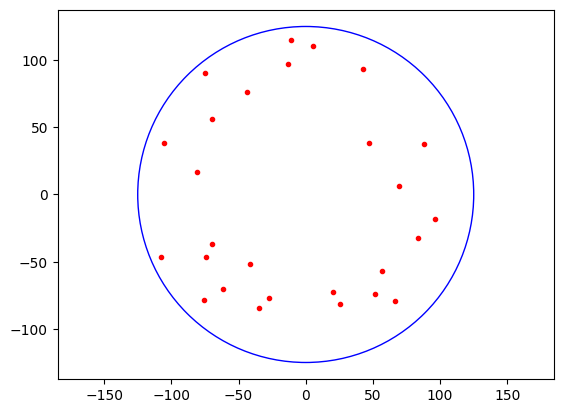

In [299]:
c = Nervio(diametro=250)
c.desde_archivo(diametro_fibra = 0,ubicacion_archivo = 'C:/Users/aguir/Desktop/Prroyecto/python/fibras_sindiametro.csv')
c.ploteo_fibras_puntos()

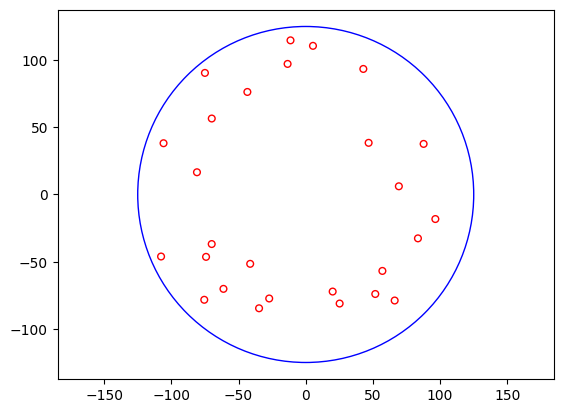

In [300]:
c = Nervio(diametro=250)
c.desde_archivo_condiametro(ubicacion_archivo = 'C:/Users/aguir/Desktop/Prroyecto/python/fibras_condiametro.csv')
c.ploteo_fibras_circulos()

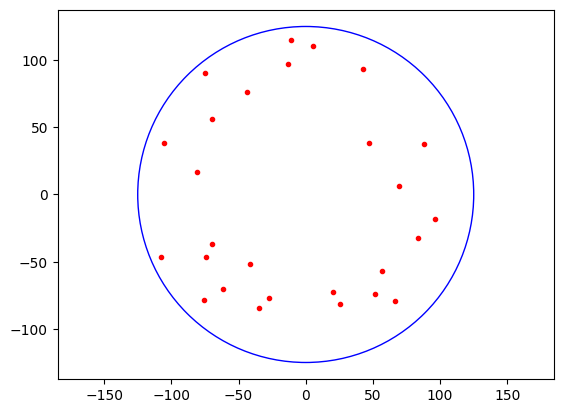

In [305]:
c = Nervio()
c.desde_archivo_final(diametro_fibra=0,ubicacion_archivo='C:/Users/aguir/Desktop/Prroyecto/python/fibras_sindiametro.csv')
#c.desde_archivo_final(diametro_fibra=0,ubicacion_archivo='C:/Users/aguir/Desktop/Prroyecto/python/fibras_condiametro.csv')
c.ploteo_fibras_puntos()
#c.ploteo_fibras_circulos()


#### <stan style = "color : orange ">Prueba del método para setear los diámetros variables de las fibras </stan>

In [ ]:
#Prueba de setear diametros de fibras
#Esto solo tendría sentido si es que comienza siendo una fibra sin diametro y después se le asigna
b = Nervio()
b.poblar(num_fibras=10)
b.setear_diametros_fibras(10,1)
b.obtener_lista_fibras()
b.ploteo_fibras_circulos()

In [ ]:
b = Nervio()
b.megauniforme(num_fibras=350,semilla=None,diametro_fibra=10,variacion=1)
b.ploteo_fibras_circulos()

### <stan style = "color : cyan ">Pruebas de objetos electrodos  </stan>

In [ ]:
a = Nervio()
a.poblar(metodo_poblacion = 'manual', lista_fibras = [[-125,0]],diametro_fibra=10)
a.ploteo_fibras_circulos()

In [ ]:
a = Nervio()
a.poblar(metodo_poblacion = 'manual', lista_fibras = [[0,0]],diametro_fibra=50)
a.ploteo_fibras_circulos()

In [ ]:
a = Nervio()
a.poblar()
a.ploteo_fibras_puntos()

In [ ]:
e = Electrodo(tipo = 'circulo',x = 0,y = -150,z = 10, radio = 5)

In [ ]:
e.calcular_distancias(a.fibras)

In [ ]:
e.dist_al_electrodo

In [ ]:
e = Electrodo(tipo = 'poligono',z = 10,lista_coordenadas = [(-125,-150),(125,-150),(125,-155),(-125,-155)])

In [ ]:
e.distancia_al_electrodo_poligono(a.fibras)

### <stan style = "color: cyan"> Ubicacion de los nodos </stan>

In [ ]:
#Uniforme
a = Nervio()
a.poblar(num_fibras=3)
a.cantidad_fibras
a.agregar_nodos(longitud_fibra=50000,distancia_nodos=10000, variacion= 0,desplazamiento=10)
a.ubicacion_nodos

In [ ]:
#Gauss
a = Nervio()
a.poblar()
a.agregar_nodos_gauss(z = 10, cantidad_nodos=5,distancia_nodos=3,sigma_desplazamiento=1,sigma_distancia=5)

### <stan style = "color : cyan ">Prueba clase Entorno  </stan>

In [ ]:
a = Entorno()
a.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=1000,longitud=50000)
a.crear_electrodo(tipo='circulo',x=0,y=-150,z=10,radio = 10)
a.crear_electrodo(tipo='circulo',x=50,y=-150,z=10,radio = 15)
a.crear_electrodo(tipo='punto',x = -50,y = -125,z = 3)
a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-25,-150),(25,-150),(25,-160),(-25,-160)],z=10)
a.dibujar_entorno(forma_ploteo='fibras_con_diametro')




In [ ]:
a.nervio.obtener_lista_fibras()

In [ ]:
a.imprimir_distancias()

#### <stan style = "color : orange ">Nodos</stan>

In [ ]:
#desde clase nervio
a = Nervio(longitud=500000)
a.poblar(num_fibras=200)
a.agregar_nodos(distancia_nodos=100,variacion=50,desplazamiento=0)
#a.informacion_nodos

In [ ]:
a.informacion_nodos

In [ ]:
#Control de que la distancia promedio entre nodos se mantiene parecida a la que yo pongo
lista = []
for x in a.informacion_nodos:
    for i in range(len(x)-1):
        lista.append(x[i+1]-x[i])
#print(lista)
print(np.mean(lista))


        

In [ ]:
#desde clase entorno
b = Entorno()
#b.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=1000,longitud=5000)
#b.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=1000,longitud=5000,desplazamiento=10)
b.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=1000,longitud=5000,variacion=10)
b.nervio.informacion_nodos


#### <stan style = "color : orange ">Distancias de las fibras al electrodo</stan>

In [ ]:
a = Entorno()
a.crear_nervio(num_fibras = 1,metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=1000,longitud=50000)
a.crear_electrodo(tipo='circulo',x=0,y=-150,z=10,radio = 10)
a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-25,-150),(25,-150),(25,-160),(-25,-160)],z=10)
a.dibujar_entorno()

a.imprimir_distancias()